In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path
from typing import Dict, List, Tuple
from loguru import logger
from src.config import DIPSTICK_IMAGES_DIR
from src.dipstick_clf.preprocessing.utils import PLAIN_CLASS_MAP, SIMPLE_CLASS_MAP, GRANULAR_CLASS_MAP, ROTATION_CLASS_MAP

2025-11-22 21:28:30.438 | INFO     | src.config:<module>:12 - PROJ_ROOT path is: /Users/Edward/DS/Projects/ckd-cdss


In [ ]:
RELABEL_METHOD = "rotation"
IMG_DIR = DIPSTICK_IMAGES_DIR / f"imgs_{RELABEL_METHOD}"

SPLIT_NAME = 'test'

class_maps = {
        "plain": PLAIN_CLASS_MAP,
        "simple": SIMPLE_CLASS_MAP,
        "granular": GRANULAR_CLASS_MAP,
        "rotation": ROTATION_CLASS_MAP
    }
CLASS_MAP = class_maps[RELABEL_METHOD]
CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}

NUM_IMAGES_TO_SHOW = 10

In [3]:
def plot_annotated_image(img_path: Path, label_path: Path, class_map: Dict[int, str], colors: Dict[str, Tuple[float, float, float]]):
    """
    Reads a single image and its YOLO annotation file, plots the bounding boxes 
    and labels using Matplotlib.
    """
    # 1. Load Image
    try:
        img = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        logger.error(f"Error: Image not found at {img_path}")
        return

    img_width, img_height = img.size
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    # 2. Load and Parse YOLO Annotations
    if not label_path.exists():
        ax.set_title(f"{img_path.name}\n(No Annotations Found)", color='red')
        plt.show()
        return

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) < 5: continue
                
            yolo_id = int(parts[0])
            
            # YOLO coordinates are normalized center_x, center_y, width, height
            x_center, y_center, w_norm, h_norm = map(float, parts[1:])

            # Convert normalized coordinates to pixel coordinates
            # x_min = (x_center - w_norm/2) * width
            x_min_pixel = int((x_center - w_norm / 2) * img_width)
            y_min_pixel = int((y_center - h_norm / 2) * img_height)
            box_width_pixel = int(w_norm * img_width)
            box_height_pixel = int(h_norm * img_height)

            class_name = class_map.get(yolo_id, f"UNKNOWN_{yolo_id}")
            color = colors.get(class_name, (1.0, 0.0, 1.0)) # Default magenta for unknown

            # 3. Draw Bounding Box
            rect = patches.Rectangle(
                (x_min_pixel, y_min_pixel), 
                box_width_pixel, 
                box_height_pixel, 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none'
            )
            ax.add_patch(rect)

            # 4. Draw Label
            plt.text(
                x_min_pixel, y_min_pixel - 5, 
                class_name, 
                color='white', 
                fontsize=8, 
                bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=2)
            )

    ax.set_title(img_path.name)
    ax.axis('off')
    plt.show()

Found 20 images in the 'valid' split.


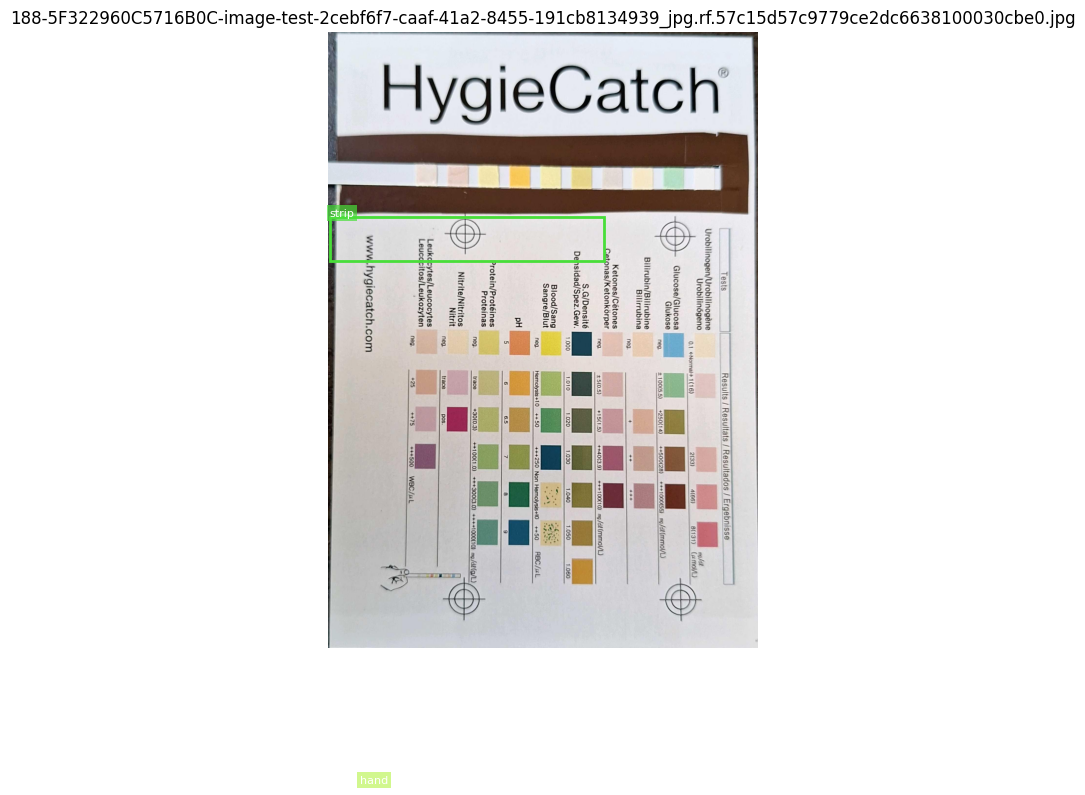

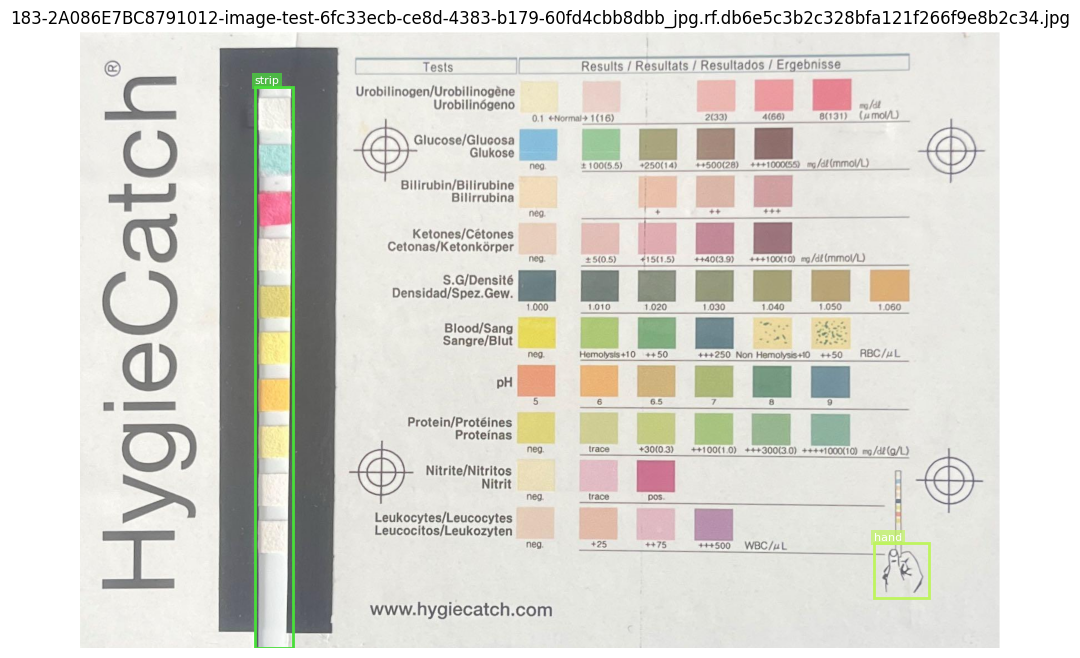

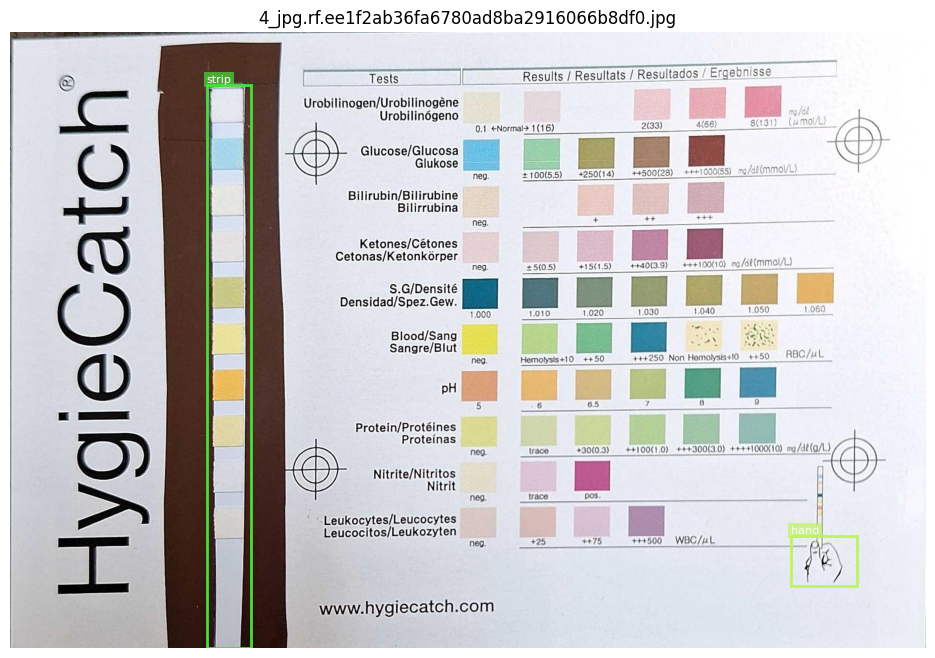

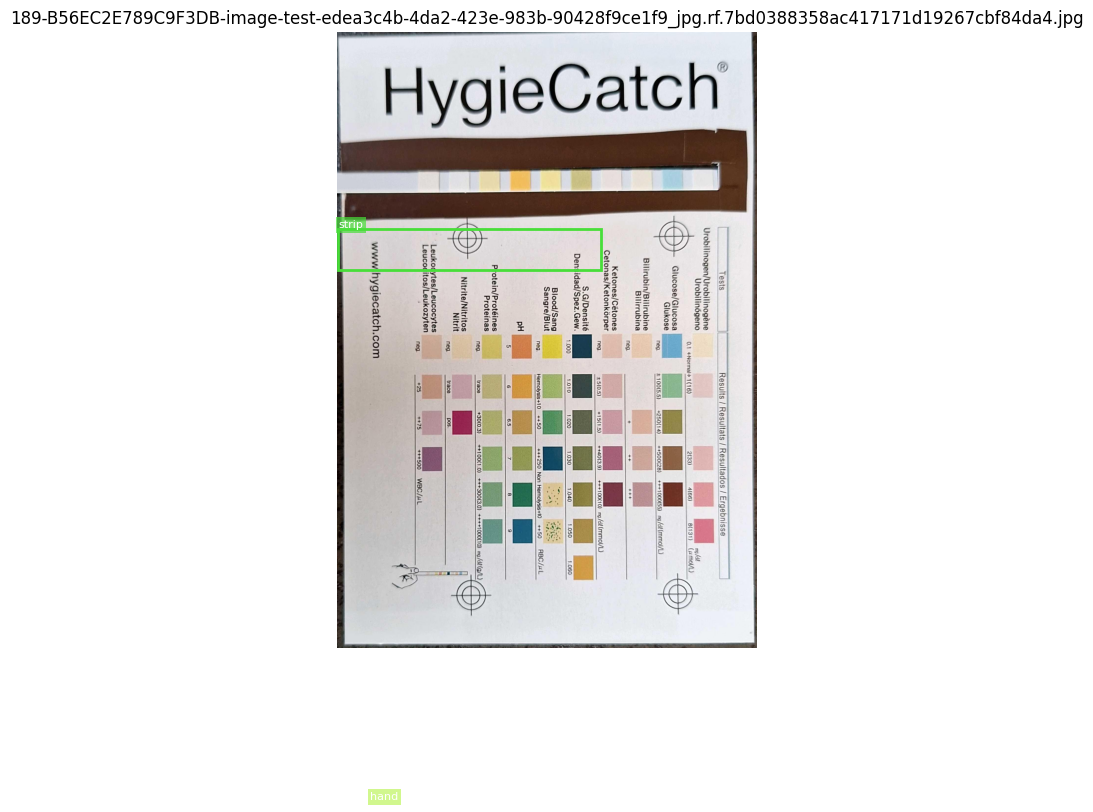

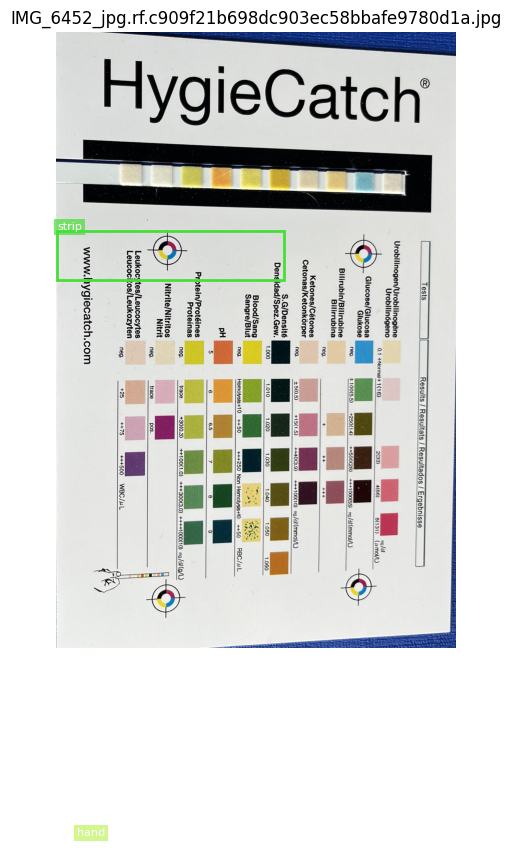

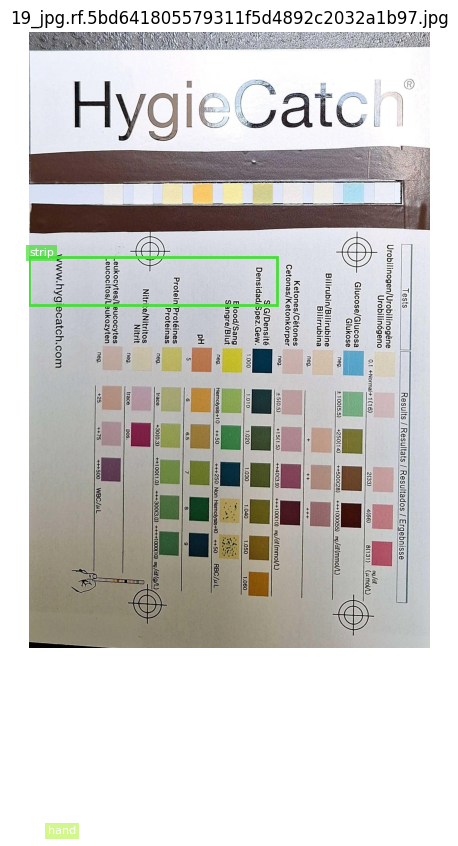

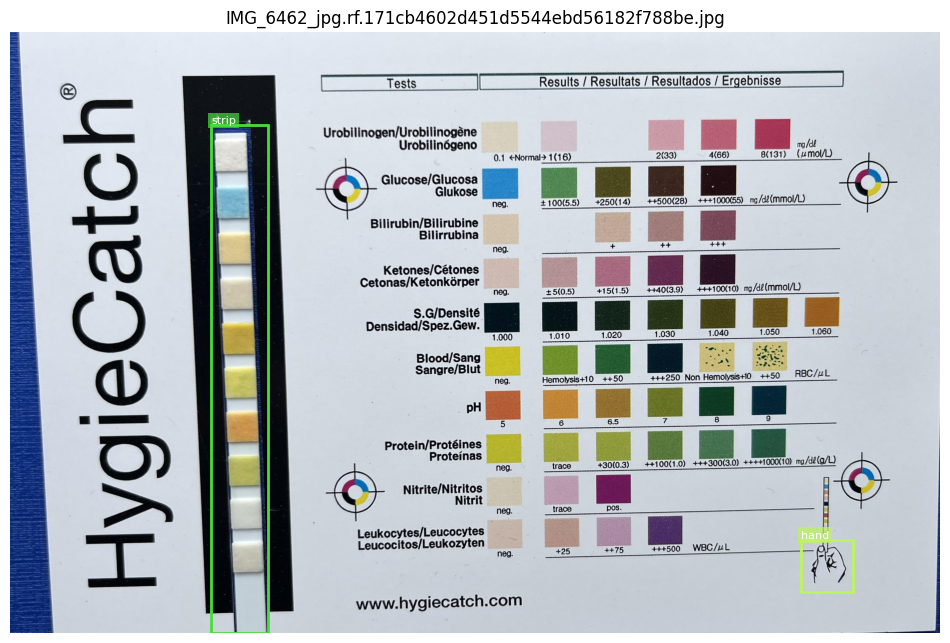

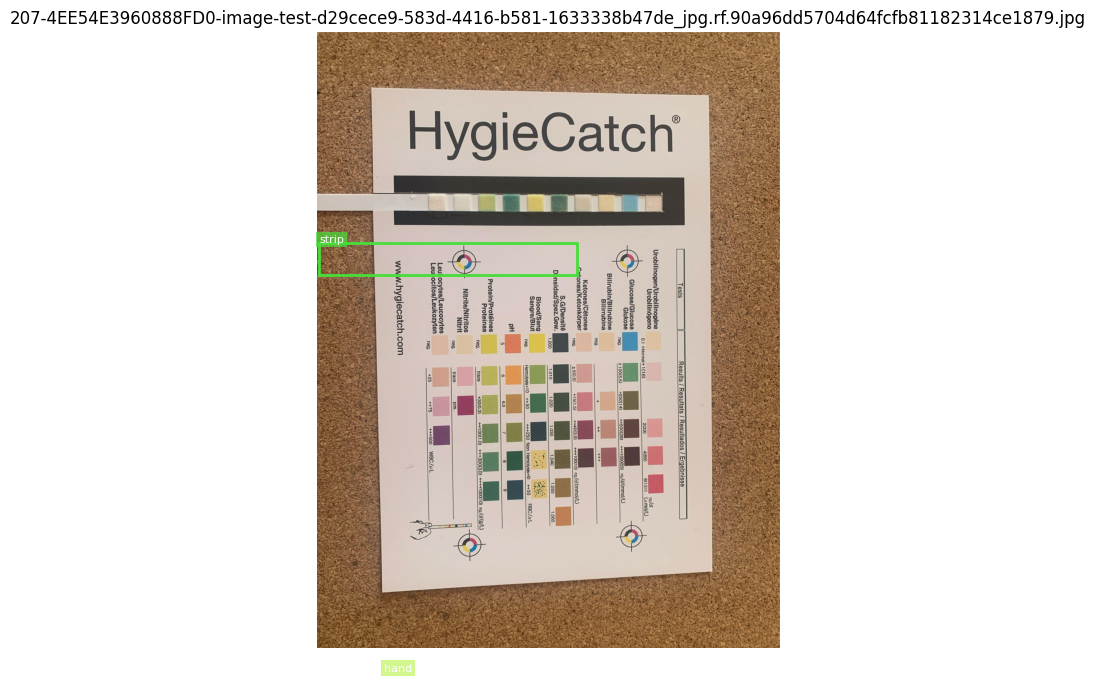

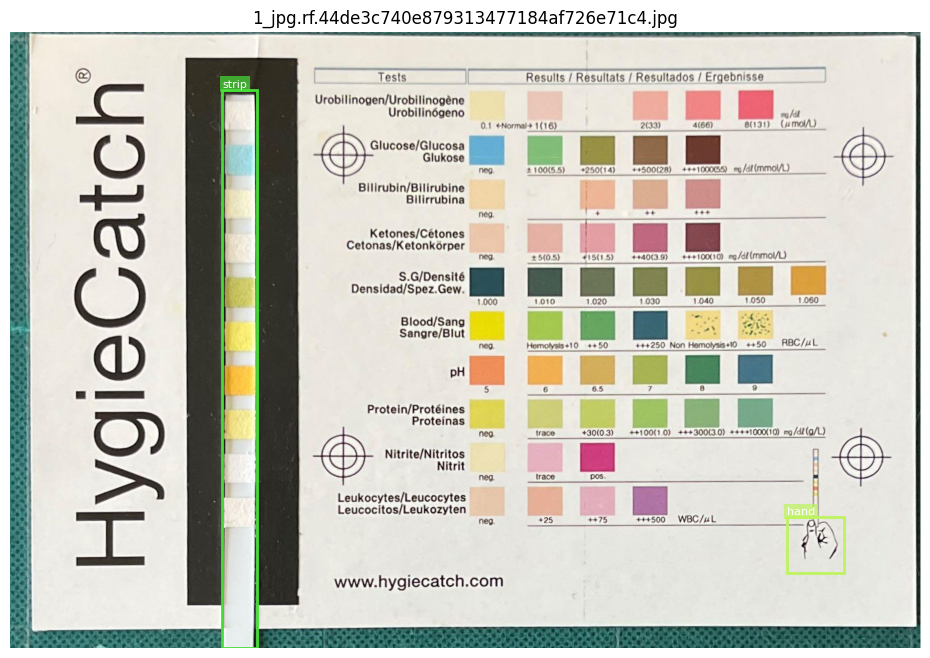

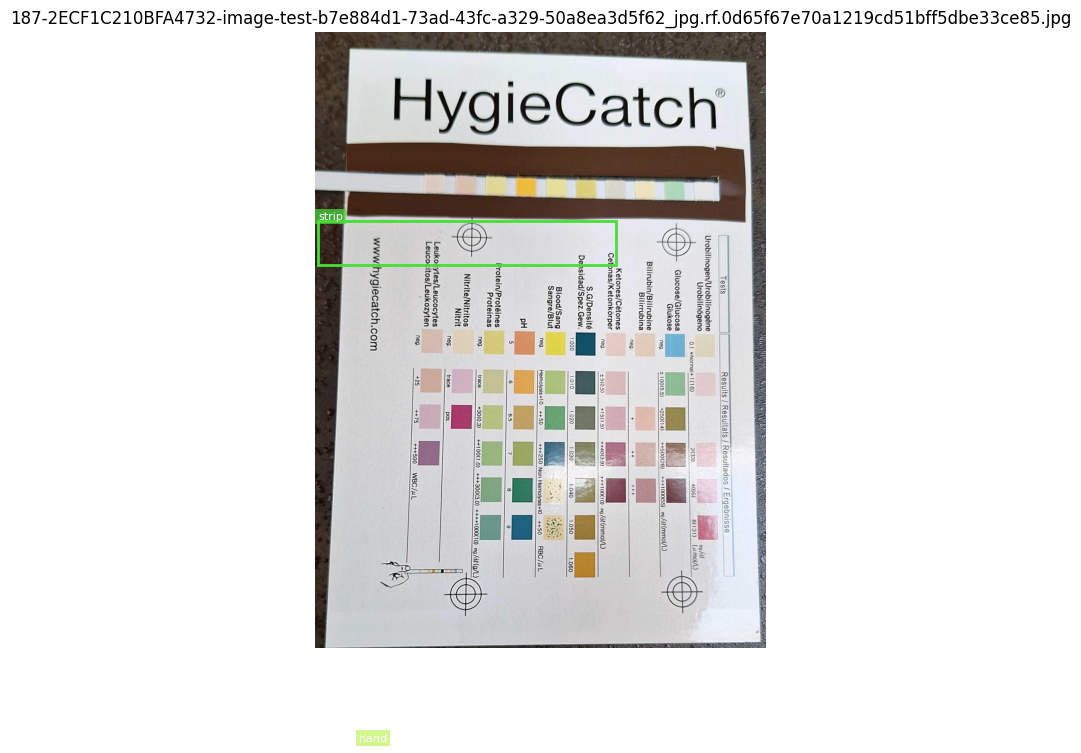

In [4]:
# Function to generate a random hex color for plotting
def get_random_color():
    return (random.random(), random.random(), random.random())

# 1. Prepare Color Map
colors = {name: get_random_color() for name in CLASS_MAP.values()}

# 2. Get File Paths
image_dir = IMG_DIR / SPLIT_NAME / 'images'
label_dir = IMG_DIR / SPLIT_NAME / 'labels'

image_files = sorted(list(image_dir.glob('*.jpg')))
if not image_files:
    print(f"Error: No JPEG images found in {image_dir}")
else:
    print(f"Found {len(image_files)} images in the '{SPLIT_NAME}' split.")

# Limit the list to the desired sample size
if NUM_IMAGES_TO_SHOW and len(image_files) > NUM_IMAGES_TO_SHOW:
    # Use random sampling for better distribution of checks
    sample_files = random.sample(image_files, NUM_IMAGES_TO_SHOW)
else:
    sample_files = image_files

# 3. Plotting Loop
for img_path in sample_files:
    label_path = label_dir / f"{img_path.stem}.txt"
    plot_annotated_image(img_path, label_path, CLASS_MAP, colors)